# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [4]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('data/steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [3]:
data_reviews = pd.DataFrame(data_reviews)

In [2]:
if True:
    data_reviews.to_csv('data_reviews.csv', index= False)

NameError: name 'data_reviews' is not defined

In [5]:
data_reviews = pd.read_csv('data_reviews.csv')
data_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


We crawled reviews and game information from Steam. The dataset contains 7,793,069 reviews, 2,567,538 users, and 32,135 games. In addition to the review text, the data also includes the users' play hours in each review.

In [6]:
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [7]:
### Cantidad de valoraciónes de un juego especifico
data_reviews[data_reviews.product_id == '35140']

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny


**Games**

In [8]:
data_games = []
for l in parse('data/steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [9]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [10]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [24]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [28]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [33]:
#Don't drop, just take the rows where EPS is not NA:
data_games = data_games[data_games['id'].notna()]
data_games['id'] = data_games['id'].astype('int')
data_games.reset_index(inplace=True)

In [34]:
data_games.shape

(32133, 18)

Agregamos al dataset el nombre del Juego

Exploracion de datos

In [35]:
## Tamaño del dataset
data_reviews.shape

(779307, 10)

In [36]:
#descarto compensation y found_funny por la gran cantidad de faltantes
data_reviews.drop(columns=['compensation', 'found_funny'], inplace=True)

KeyError: "['compensation' 'found_funny'] not found in axis"

In [38]:
data_reviews.isna().sum()

username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
dtype: int64

In [39]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      779289 non-null  object 
 1   hours         776670 non-null  float64
 2   products      777741 non-null  float64
 3   product_id    779307 non-null  int64  
 4   page_order    779307 non-null  int64  
 5   date          779307 non-null  object 
 6   text          777468 non-null  object 
 7   early_access  779307 non-null  bool   
 8   page          779307 non-null  int64  
 9   user_id       317340 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(3)
memory usage: 54.3+ MB


KeyboardInterrupt: 

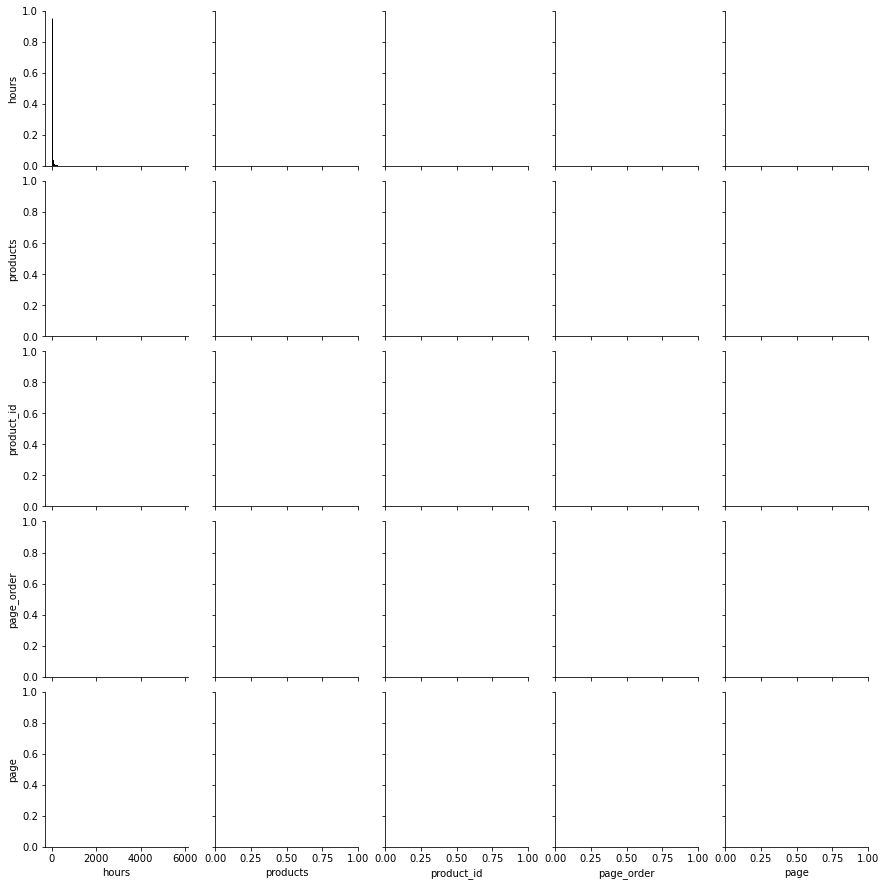

In [40]:
### vemos las ditribuciones de las variables
import seaborn as sns, numpy as np
#ax = sns.distplot(data_reviews['hours'])
dataplot = data_reviews[['hours','products','product_id','page_order','page']]
sns.pairplot(dataplot)

In [43]:
data = data_reviews[data_reviews['product_id'].isin(data_games['id'])]
#data = data[['userId','movieId','rating']]
data.head()
print(data.shape)

(779307, 10)


In [17]:
data_reviews.shape

(779307, 10)

In [44]:
data_reviews_2 = data_reviews[['username','product_id']]
data_reviews_2

,username,product_id
0,Chaos Syren,725280
1,Ariman1,328100
2,freakfantom,725280
3,The_Cpt_FROGGY,631920
4,the_maker988,35140
...,...,...
779302,Vidaar,252490
779303,Nikolai Belinski,252490
779304,RancorZealot,252490
779305,Jerry,252490


In [45]:
data_games.shape

(32133, 18)

In [46]:
#https://interactivechaos.com/es/manual/tutorial-de-pandas/dataframes-la-funcion-merge
mergeado = pd.merge(data_reviews_2,data_games, left_on = "product_id", right_on = "id")

In [47]:
mergeado.head()

,username,product_id,level_0,index,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Chaos Syren,725280,14172,14173,Vyacheslav Shilikhin,"[Action, Adventure, Indie, Simulation]",Psi Project,Psi Project,http://store.steampowered.com/app/725280/Psi_P...,2017-11-10,"[Action, Adventure, Indie, Simulation]",NaN,http://steamcommunity.com/app/725280/reviews/?...,"[Single-player, Steam Trading Cards]",2.99,False,725280,Vyacheslav Shilikhin,Positive,NaN
1,freakfantom,725280,14172,14173,Vyacheslav Shilikhin,"[Action, Adventure, Indie, Simulation]",Psi Project,Psi Project,http://store.steampowered.com/app/725280/Psi_P...,2017-11-10,"[Action, Adventure, Indie, Simulation]",NaN,http://steamcommunity.com/app/725280/reviews/?...,"[Single-player, Steam Trading Cards]",2.99,False,725280,Vyacheslav Shilikhin,Positive,NaN
2,Ariman1,328100,2833,2834,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,Gunspell - Steam Edition,http://store.steampowered.com/app/328100/Gunsp...,2014-11-07,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.99,False,328100,Ino-Co Plus,Mixed,NaN
3,dll3z,328100,2833,2834,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,Gunspell - Steam Edition,http://store.steampowered.com/app/328100/Gunsp...,2014-11-07,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.99,False,328100,Ino-Co Plus,Mixed,NaN
4,Nyazicat,328100,2833,2834,KISS ltd,"[Adventure, Indie, RPG]",Gunspell - Steam Edition,Gunspell - Steam Edition,http://store.steampowered.com/app/328100/Gunsp...,2014-11-07,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.99,False,328100,Ino-Co Plus,Mixed,NaN


In [48]:
mergeado[['username','product_id','title']]

,username,product_id,title
0,Chaos Syren,725280,Psi Project
1,freakfantom,725280,Psi Project
2,Ariman1,328100,Gunspell - Steam Edition
3,dll3z,328100,Gunspell - Steam Edition
4,Nyazicat,328100,Gunspell - Steam Edition
...,...,...,...
779946,rt974,518790,theHunter: Call of the Wild™
779947,Fallenglory,518790,theHunter: Call of the Wild™
779948,GooseMan,518790,theHunter: Call of the Wild™
779949,lazyboy82,518790,theHunter: Call of the Wild™


#### Graficar
- Cantidad de video Juegos por usuarios
- Videos Juegos Vs Precios

55555555555555


3333333333333